# **networkh3 usage**

networkh3 is a package that returns clipped H3 hexagons from the extent of an OSMnx network. It is useful for anyone looking to use the H3 spatial indexing system in route analyses or spatial analyses, and for saving time sourcing H3 hexagons.

networkh3 can be easily installed using pip:

In [ ]:
pip install networkh3

There are three main uses for networkh3. First, it can be used to simply call a network for an area of interest (AOI) and plot it against a standout background that helps demarcate the AOI from surrounding areas. Second, the clipped H3 hexagons can be used in spatial analyses, bringing the [benefits](https://www.uber.com/en-GB/blog/h3/) of the H3 spatial indexing system. Third, the network can be used in subsequent network analyses like any other [OSMnx](https://github.com/gboeing/osmnx-examples) network.

### **1. Plotting**

Calling the _get_h3_ function automatically returns a figure of the network and clipped H3 hexagons. The function requires three parameters: the AOI (using OpenStreetMap area tags), the network type (drive/bike/walk), and the resolution of the H3 hexagons (where 1 is the most coarse hexagon size and 16 the finest).

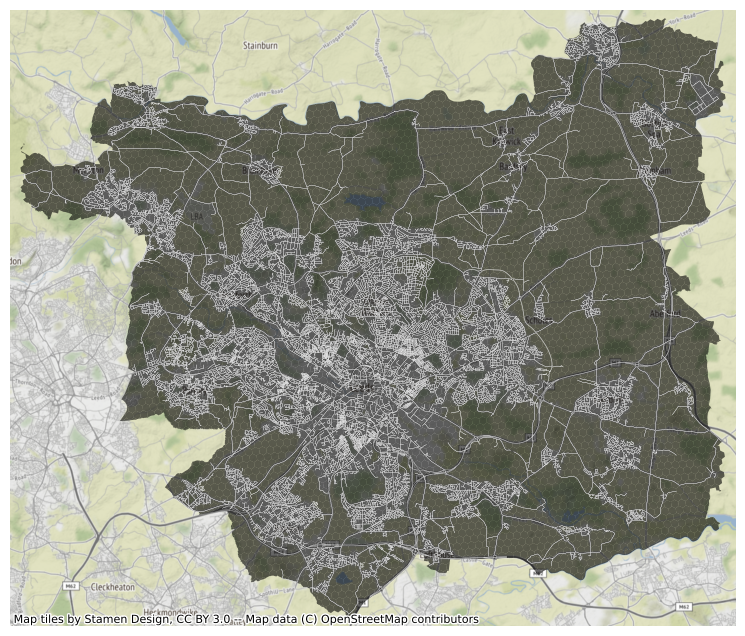

In [75]:
from networkh3 import NETWORKH3

NETWORKH3.get_h3('Leeds, England', 'drive', 9)

By default, the network is plotted in white with a node size of 1 against a slightly transparent background of black H3 hexagons and an OpenStreetMap basemap with an automatic zoom level.

However, kwargs can also be specified to style the plot:

*   *network_kwargs* style the network and are passed to the *plot_graph()* function of OSMnx
*   *h3_kwargs* style the H3 hexagons and are passed to the *plot()* function of geopandas
*   *basemap_kwargs* style the basemap and are passed to the *add_basemap()* function of contextily




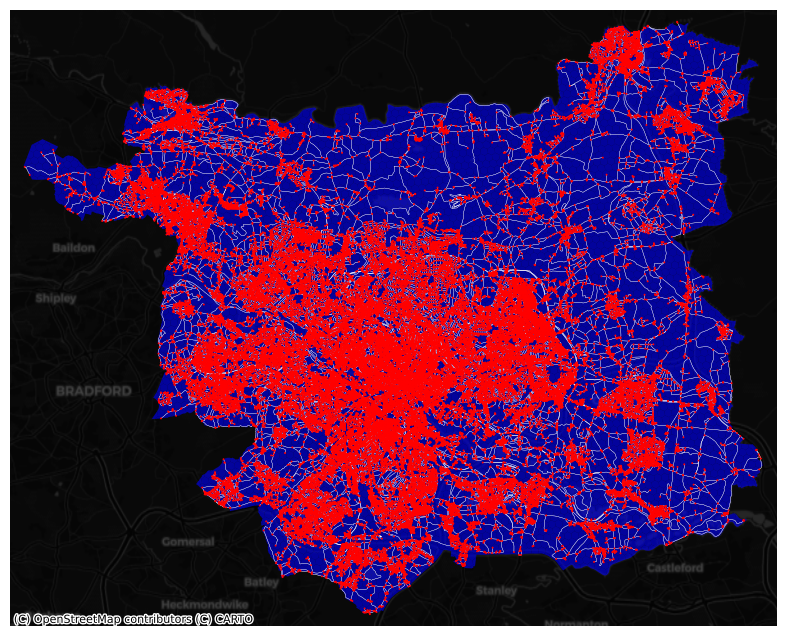

In [76]:
from networkh3 import NETWORKH3
import contextily as cx

NETWORKH3.get_h3('Leeds, England', 'walk', 9,
                 network_kwargs = {'node_color':'red', 'node_size':2},
                 h3_kwargs = {'facecolor':'blue', 'linewidth': 0.8},
                 basemap_kwargs = {'source' : cx.providers.CartoDB.DarkMatter, 'zoom':11})

### **2. Network analysis**

The network is returned as a MultiDiGraph object that can be used like any other in the [OSMnx](https://github.com/gboeing/osmnx-examples/tree/main) package.

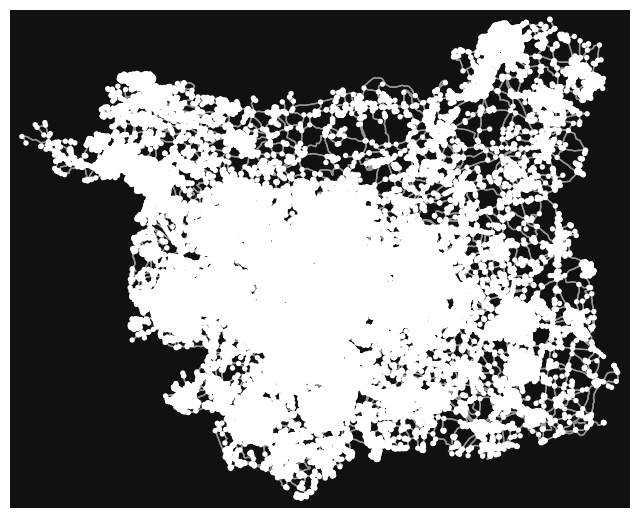

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [77]:
from networkh3 import NETWORKH3
import osmnx as ox

ox.plot_graph(NETWORKH3.network)

Various network analysis operations can be performed using OSMnx, such as calculating the shortest route between two nodes or building isochrones that show the distance one could cover from a given node in a given time. Examples are taken from the OSMnx [notebooks](https://github.com/gboeing/osmnx-examples/tree/main/notebooks).

#### **Shortest distance**

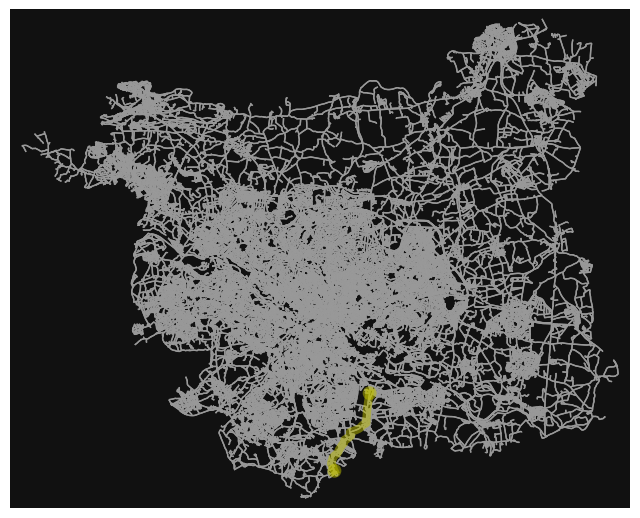

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [78]:
# Projecting the network to UTM
G = ox.project_graph(NETWORKH3.network)

# Calculating shortest distances between two random nodes in the network
origin = list(G)[0]
destination = list(G)[120]
route = ox.shortest_path(G, origin, destination, weight="length")
ox.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)

#### **Isochrones**

In [79]:
# Packages required for OSMnx isochrone creation
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

In [80]:
# Defining the isochrone boundaries and travel speed
trip_times = [30, 60, 90, 120, 150]  # Trip length in minutes
travel_speed = 4.5  # Walking speed in km/hour

In [81]:
# Finding the centermost node of the network
gdf_nodes = ox.graph_to_gdfs(NETWORKH3.network, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(NETWORKH3.network, x[0], y[0])

# Projecting the network to UTM (for distance based measurements)
G = ox.project_graph(NETWORKH3.network)

In [82]:
# Adding an attribute to each edge of the time in minutes required to traverse the edge
meters_per_minute = travel_speed * 1000 / 60
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [83]:
# Making the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

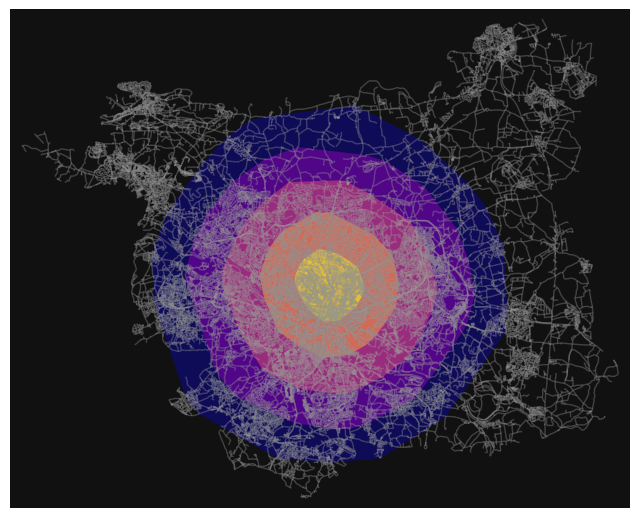

In [84]:
# Assigning one colour to each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

# Plotting the network then adding the isochrones as coloured polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

### **3. Spatial analysis**

The clipped H3 hexagons are returned as a geodataframe. These can be used for spatial analyses such as creating choropleth maps or calculating spatial clustering.

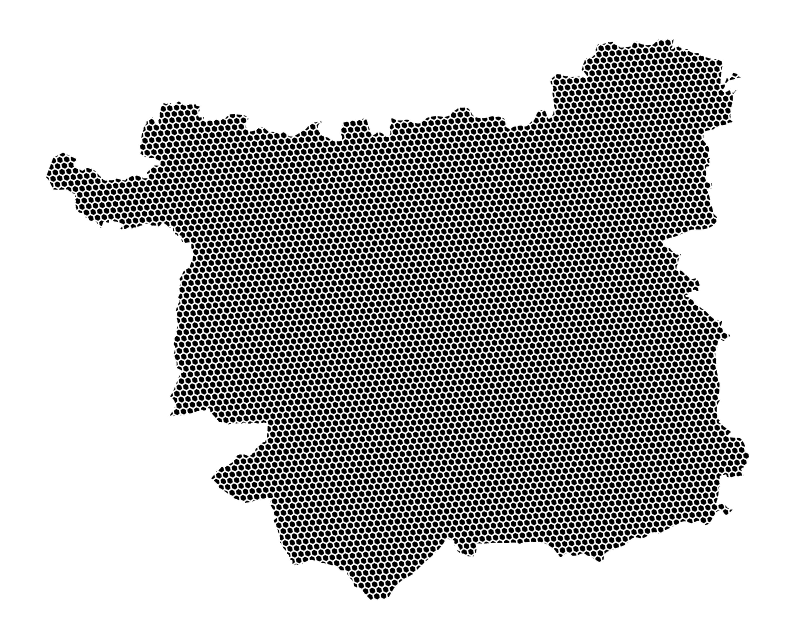

In [85]:
from networkh3 import NETWORKH3
import osmnx as ox

# Getting the clipped H3 hexagons
gdf = NETWORKH3.h3.copy().to_crs('27700').reset_index()

# Plotting the clipped H3 hexagons
fig = gdf.plot(edgecolor = 'white', facecolor = 'black', figsize = (10,10))
fig.set_axis_off()

<ipython-input-86-c062f8536593>:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  points = gdf_union.sample_points(20000).explode(ignore_index=False, index_parts=None).reset_index().drop(['outline', 'level_1'], axis = 1).to_crs('27700')


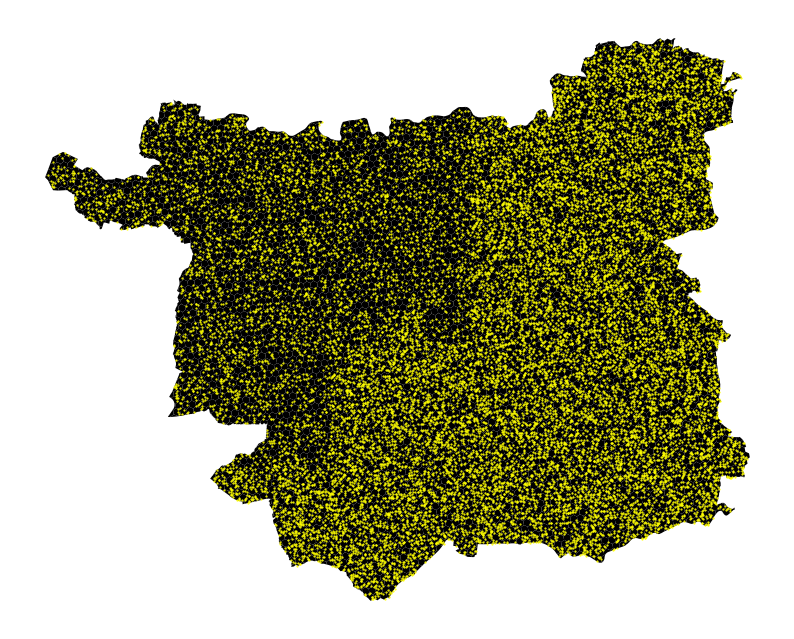

In [86]:
# Sampling random points within the extent of the hexagon boundaries
gdf['outline'] = 0
gdf_union = gdf.dissolve(by='outline')
points = gdf_union.sample_points(20000).explode(ignore_index=False, index_parts=None).reset_index().drop(['outline', 'level_1'], axis = 1).to_crs('27700')

fig, ax = plt.subplots(figsize = (10,10))
gdf.plot(ax=ax, facecolor = 'black')
points.plot(ax=ax, facecolor = 'yellow', markersize = 0.3)
ax.set_axis_off()

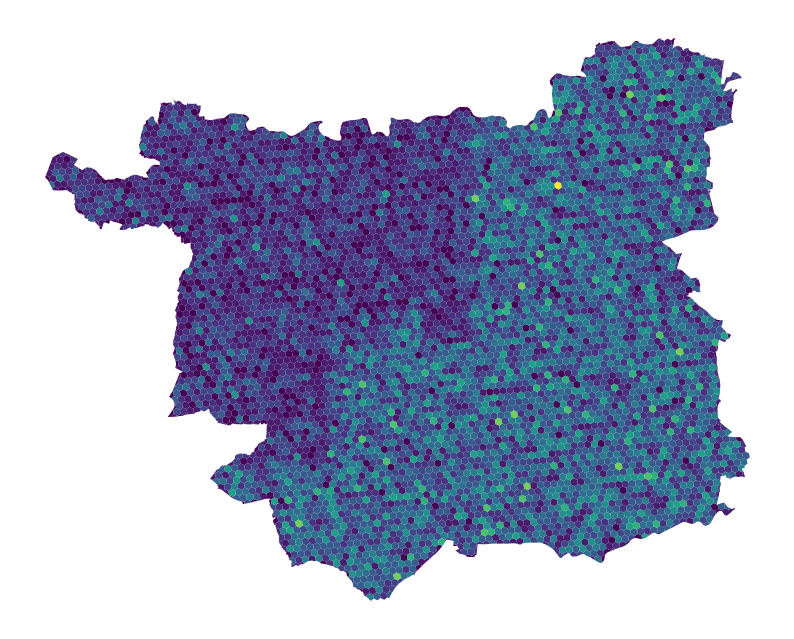

In [87]:
# Spatial intersect to find the points within each hexagon
points_in_lsoa = gpd.sjoin(points, gdf, predicate='intersects')

# Grouping by hexagon code and counting the number of points in each hexagon
points_in_lsoa = points_in_lsoa.groupby('h3_polyfill').agg({'sampled_points': 'count'}).reset_index()

# Joining the gdf with the geometry of each hexagon to the grouped dataframe
density = gdf.join(points_in_lsoa.set_index('h3_polyfill'), on = 'h3_polyfill').drop(['outline'], axis = 1).fillna(0)

# Plotting the density of points in each hexagon
fig = density.plot('sampled_points', figsize = (10,10))
fig.set_axis_off()

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

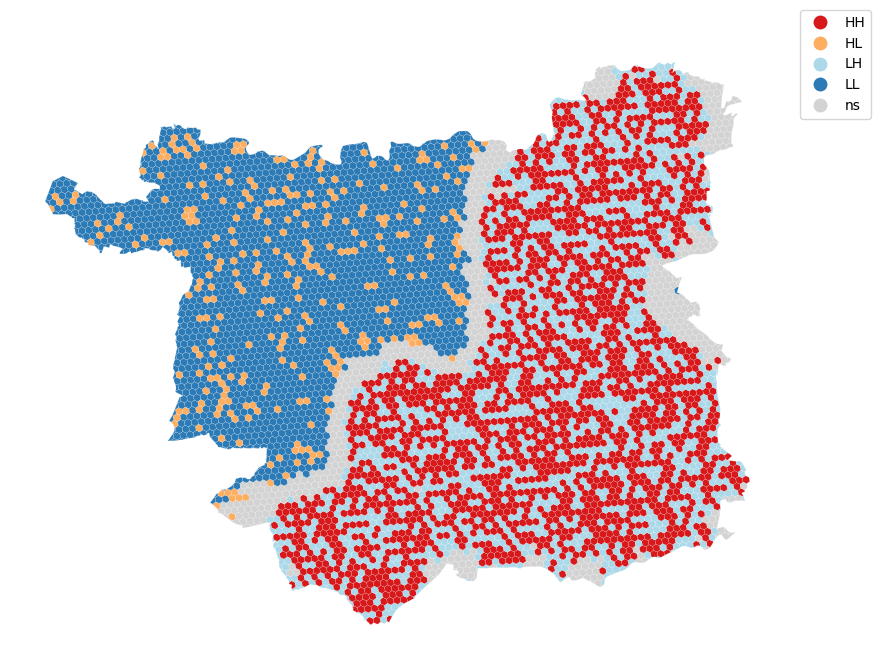

In [88]:
# Importing required modules for KNN spatial clustering
import math
import pysal
import libpysal
from pysal.viz import splot
from libpysal import weights
from pysal.explore import esda
from pysal.viz import mapclassify
from sklearn.cluster import KMeans
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# Calculating KNN spatial weights
w_k = weights.KNN.from_dataframe(density, k = (math.sqrt(len(density))))

# Using the weights to calculate the spatial clustering of the sampled points
lisa = esda.Moran_Local(density['sampled_points'], w_k)

# Plotting the clusters
lisa_cluster(lisa, density, legend_kwds={'loc': 'upper right', 'bbox_to_anchor': (1.12, 1.05)}, figsize = (10,10))

Any number of spatial and network operations can be performed on the objects returned by the networkh3 package. Rey, Arribas-Bell, and Wolf's online [book](https://geographicdata.science/book/intro.html) gives detailed examples of many spatial analysis concepts.

If you encounter any errors or wish to contribute to this project, please log the issue or create a pull request.